In [1]:
import os
os.chdir("/home/sebastian/Projects/ABC/cadmesh/")

from tqdm.auto import tqdm
import glob
from pathlib import Path
import os

from cadmesh import StepProcessor


def process(convert=False, rang=[0, 10000], data_path="./data/conv/", output_path="./results_fixed", data_format="yaml", proc_list=[], skip_list=[], fix=False):
    data_dir = Path(data_path)
    output_dir = Path(output_path)
    
    print(os.getcwd())
    
    # Glob step files in data dir
    extensions = ["stp", "step"]
    step_files = []
    for ext in extensions:
        files = [ f for f in data_dir.glob(f"*.{ext}")]
        step_files.extend(sorted(files))
        
    step_files = step_files[rang[0]:rang[1]]
              
    # Process step files
    pbar = tqdm(range(len(step_files)))
    for i in pbar:
        pbar.set_description("Processing %s"%step_files[i])
        sf = step_files[i]
#         stats_yaml = output_dir / f"{sf.stem}_stat.yaml"
#         if os.path.exists(stats_yaml):
#             print("Skipping %s"%sf)
#             continue

#         skippers = ["00000048","00000560","00000700","00000978","00000414","00003483","00001996","00002501","00002550","00005587","00003087",
#                     "00003094","00005410","00006679","00006741","00006747","00008287","00007501","00008660","00009272","00007744","00003752",
#                     "00000730","00005641","00005642","00007894","00003902","00003946","00000959","00005687","00005986","00005987","00005988",
#                     "00005759","00000988","00000787","00005760","00000790","00005786"]
        if len(skip_list) > 0 and len(proc_list) == 0:
            proc = True
            for s in skip_list:
                if "%08i"%s in sf.stem:
                    proc = False
        elif len(skip_list) == 0 and len(proc_list) > 0:
            proc = False
            for s in proc_list:
                if "%08i"%s in sf.stem:
                    proc = True
        else:
            proc = True
        
        if proc:
            log_dir = output_dir.stem.replace("results", "log")
            sp = StepProcessor(sf, output_dir, log_dir)
            sp.load_step_file()
            sp.process_parts()
            #process_step_file(sf, convert, output_dir, data_format, fix)

process(rang=[0, 20], data_path="data/simple/")

/home/sebastian/Projects/ABC/cadmesh


In [20]:
import glob
from tqdm.auto import tqdm
import datetime
logs = sorted(glob.glob("log_abc_00uc/*.log"))

times = []
parts = []
errors = []
elogs = []
n_errors = []
n_elogs = []
success = []

pbar = tqdm(range(len(logs)))
for i in pbar:
    #pbar.set_description("Processing %s"%logs[i])
    log = logs[i]
    with open(log, "r") as fi:
        lines = fi.readlines()
        
    if len(lines) < 2:
        errors.append(i)
        elogs.append("%i: %s"%(i, "Lines missing"))
        continue
    time_start = " ".join(lines[0].split(" ")[:2])[:-4]
    time_end = " ".join(lines[-1].split(" ")[:2])[:-4]
    #for line in lines:
    t_s = datetime.datetime.strptime(time_start, '%Y-%m-%d %H:%M:%S')
    t_e = datetime.datetime.strptime(time_end, '%Y-%m-%d %H:%M:%S')
    times.append((t_e - t_s).total_seconds())
    
    try:
        parts.append(int(lines[1].split(" ")[5]))
    except:
        parts.append(0)
        errors.append(i)
        elogs.append("%i: %s"%(i, "Translation problem"))
    
    for line in lines:
        if "ERROR" in line and "Nurbs conversion error" in line:
            n_errors.append(i)
            n_elogs.append("%i: %s"%(i, line))
        elif "ERROR" in line and not "Nurbs conversion error" in line:
            errors.append(i)
            elogs.append("%i: %s"%(i, line))
            
        if "Stat dict: Done" in line:
            success.append(i)

In [19]:
succ_conv = []
for i in success:
    succ_conv.append(logs[i].split("/")[1].split("_")[0])
print(len(succ_conv), succ_conv[0:10])

9958 ['00000000', '00000001', '00000002', '00000003', '00000004', '00000005', '00000006', '00000007', '00000008', '00000009']


In [21]:
succ_org = []
for i in success:
    succ_org.append(logs[i].split("/")[1].split("_")[0])
print(len(succ_org), succ_org[0:10])

9919 ['00000000', '00000001', '00000002', '00000003', '00000004', '00000005', '00000006', '00000007', '00000008', '00000009']


In [50]:
both = []
only_conv = []
only_org = []
for i in succ_conv:
    if i in succ_org:
        both.append(i)
    else:
        only_conv.append(i)
for j in succ_org:
    if j not in succ_conv:
        only_org.append(j)

print(len(both), len(only_conv), len(only_org))
print(both[:20])

9918 40 1
['00000000', '00000001', '00000002', '00000003', '00000004', '00000005', '00000006', '00000007', '00000008', '00000009', '00000010', '00000011', '00000012', '00000013', '00000014', '00000015', '00000016', '00000017', '00000018', '00000019']


In [42]:
from utils import load_dictionary_from_file
for m in both[0:1000]:
    f1 = sorted(glob.glob("results_abc_00/%s*.yaml"%m))
    f2 = sorted(glob.glob("results_abc_00uc/%s*.yaml"%m))
    geo_f1 = load_dictionary_from_file(f1[0])
    geo_f2 = load_dictionary_from_file(f2[0])
    stat_f1 = load_dictionary_from_file(f1[1])
    stat_f2 = load_dictionary_from_file(f2[1])
    
    for part_idx in range(len(geo_f1["parts"])):
        gf1 = geo_f1["parts"][part_idx]
        gf2 = geo_f2["parts"][part_idx]
        sf1 = stat_f1["parts"][part_idx]
        sf2 = stat_f2["parts"][part_idx]
        for surf_idx in range(len(sf1)):
            try:
                if (sf2[surf_idx]["nr_singularities"] > 0 or sf1[surf_idx]["nr_singularities"] > 0) and not (gf2["surfaces"][surf_idx]["type"] == "Torus" or gf2["surfaces"][surf_idx]["type"] == "Sphere" or gf2["surfaces"][surf_idx]["type"] == "Cone"):
                    print(f1[0])
                    print(gf1["surfaces"][surf_idx]["type"], sf1[surf_idx]["has_singularities"], sf1[surf_idx]["nr_singularities"])
                    print(gf2["surfaces"][surf_idx]["type"], sf2[surf_idx]["has_singularities"], sf2[surf_idx]["nr_singularities"])   
            except Exception as e:
                print(e)
                
        #print(len(gf1["surfaces"]), len(sf1))

results_abc_00/00000011_e909f412cda24521865fac0f_step_000_geo.yaml
BSpline True 1
BSpline True 1
results_abc_00/00000011_e909f412cda24521865fac0f_step_000_geo.yaml
BSpline True 2
BSpline True 2
results_abc_00/00000011_e909f412cda24521865fac0f_step_000_geo.yaml
BSpline True 1
BSpline True 1
results_abc_00/00000011_e909f412cda24521865fac0f_step_000_geo.yaml
BSpline True 1
BSpline True 1
results_abc_00/00000011_e909f412cda24521865fac0f_step_000_geo.yaml
BSpline True 1
BSpline True 1
results_abc_00/00000011_e909f412cda24521865fac0f_step_000_geo.yaml
BSpline True 1
BSpline True 1
results_abc_00/00000011_e909f412cda24521865fac0f_step_000_geo.yaml
BSpline True 1
BSpline True 1
results_abc_00/00000011_e909f412cda24521865fac0f_step_000_geo.yaml
BSpline True 1
BSpline True 1
results_abc_00/00000012_f16882934f314832b639ffc0_step_000_geo.yaml
BSpline True 1
BSpline True 1
results_abc_00/00000012_f16882934f314832b639ffc0_step_000_geo.yaml
BSpline True 2
BSpline True 2
results_abc_00/00000012_f16882

results_abc_00/00000210_33bd159d563f438fbbebd9fa_step_002_stat.yaml 16 Cone 1
Broken surface lengths results_abc_00/00000210_33bd159d563f438fbbebd9fa_step_002_stat.yaml 67
results_abc_00/00000217_5324c79b172f41e8a49afc6f_step_004_stat.yaml 0 Revolution 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-1.449999…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.9269908…

results_abc_00/00000217_5324c79b172f41e8a49afc6f_step_004_stat.yaml 2 Revolution 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.0000000…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.1415926…

results_abc_00/00000217_5324c79b172f41e8a49afc6f_step_004_stat.yaml 14 Revolution 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-1.000000…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.1415926…

results_abc_00/00000217_5324c79b172f41e8a49afc6f_step_004_stat.yaml 17 Revolution 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.21…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.1415926…

results_abc_00/00000217_5324c79b172f41e8a49afc6f_step_004_stat.yaml 57 Revolution 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.4499999…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.4977872…

results_abc_00/00000217_5324c79b172f41e8a49afc6f_step_004_stat.yaml 58 Revolution 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.4499999…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.4977872…

results_abc_00/00000217_5324c79b172f41e8a49afc6f_step_004_stat.yaml 60 Revolution 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-1.449999…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.9269908…

results_abc_00/00000217_5324c79b172f41e8a49afc6f_step_004_stat.yaml 0 Revolution 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-1.045958…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.4977872…

results_abc_00/00000217_5324c79b172f41e8a49afc6f_step_004_stat.yaml 0 Revolution 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.045958…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.4977872…

results_abc_00/00000217_5324c79b172f41e8a49afc6f_step_004_stat.yaml 0 Revolution 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.9540416…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.4977872…

results_abc_00/00000217_5324c79b172f41e8a49afc6f_step_004_stat.yaml 0 Revolution 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.0459583…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.7853981…

results_abc_00/00000217_5324c79b172f41e8a49afc6f_step_004_stat.yaml 0 Revolution 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0459583…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.7853981…

results_abc_00/00000217_5324c79b172f41e8a49afc6f_step_004_stat.yaml 0 Revolution 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.954041…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.7853981…

results_abc_00/00000217_5324c79b172f41e8a49afc6f_step_004_stat.yaml 0 Revolution 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-1.207327…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(4.7123891…

results_abc_00/00000217_5324c79b172f41e8a49afc6f_step_004_stat.yaml 0 Revolution 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.2073279…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.5707963…

results_abc_00/00000217_5324c79b172f41e8a49afc6f_step_004_stat.yaml 0 Revolution 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-1.207327…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.5707963…

results_abc_00/00000217_5324c79b172f41e8a49afc6f_step_004_stat.yaml 0 Revolution 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.2073279…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(4.7123891…

results_abc_00/00000217_5324c79b172f41e8a49afc6f_step_004_stat.yaml 1 Revolution 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.699999…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(2.3561945…

results_abc_00/00000217_5324c79b172f41e8a49afc6f_step_004_stat.yaml 3 Revolution 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.6999999…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.7853981…

results_abc_00/00000217_5324c79b172f41e8a49afc6f_step_004_stat.yaml 15 Revolution 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.6999999…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.4977872…

results_abc_00/00000217_5324c79b172f41e8a49afc6f_step_004_stat.yaml 24 Revolution 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.699999…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.9269908…

results_abc_00/00000217_5324c79b172f41e8a49afc6f_step_004_stat.yaml 25 Revolution 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.699999…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(2.3561945…

results_abc_00/00000217_5324c79b172f41e8a49afc6f_step_004_stat.yaml 42 Revolution 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.6999999…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.7853981…

results_abc_00/00000217_5324c79b172f41e8a49afc6f_step_004_stat.yaml 46 Revolution 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.699999…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.9269908…

results_abc_00/00000217_5324c79b172f41e8a49afc6f_step_004_stat.yaml 64 Revolution 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.6999999…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.4977872…

results_abc_00/00000218_5324c79b172f41e8a49afc6f_step_005_stat.yaml 44 Revolution 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-4.900000…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.7853981…

results_abc_00/00000218_5324c79b172f41e8a49afc6f_step_005_stat.yaml 49 Revolution 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-4.900000…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.7853981…

results_abc_00/00000218_5324c79b172f41e8a49afc6f_step_005_stat.yaml 51 Revolution 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-4.900000…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.7853981…

results_abc_00/00000218_5324c79b172f41e8a49afc6f_step_005_stat.yaml 57 Revolution 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(27.699999…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.7853981…

results_abc_00/00000218_5324c79b172f41e8a49afc6f_step_005_stat.yaml 61 Revolution 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(27.699999…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.7853981…

results_abc_00/00000218_5324c79b172f41e8a49afc6f_step_005_stat.yaml 64 Revolution 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(27.699999…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.7853981…

results_abc_00/00000218_5324c79b172f41e8a49afc6f_step_005_stat.yaml 73 Revolution 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-4.900000…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.7853981…

results_abc_00/00000218_5324c79b172f41e8a49afc6f_step_005_stat.yaml 77 Revolution 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(27.699999…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.7853981…

results_abc_00/00000218_5324c79b172f41e8a49afc6f_step_005_stat.yaml 84 BSpline 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(22.616227…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.6746678…

results_abc_00/00000218_5324c79b172f41e8a49afc6f_step_005_stat.yaml 85 BSpline 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.1837722…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.5843879…

results_abc_00/00000218_5324c79b172f41e8a49afc6f_step_005_stat.yaml 92 BSpline 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.1837722…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.6746678…

results_abc_00/00000218_5324c79b172f41e8a49afc6f_step_005_stat.yaml 94 BSpline 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(22.616227…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.5843879…

results_abc_00/00000219_5324c79b172f41e8a49afc6f_step_006_stat.yaml 2 Sphere 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0001280…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.1415927…

results_abc_00/00000219_5324c79b172f41e8a49afc6f_step_006_stat.yaml 2 Cone 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(33.611312…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.1415927…

results_abc_00/00000222_97b354a907114b7183faa9c4_step_000_stat.yaml 0 Sphere 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0002052…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.1415927…

results_abc_00/00000222_97b354a907114b7183faa9c4_step_000_stat.yaml 3 Sphere 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.000327…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.1415927…

results_abc_00/00000222_97b354a907114b7183faa9c4_step_000_stat.yaml 7 Cone 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(9.2685222…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.1415927…

results_abc_00/00000225_9a5e4860c0044dd9825667d2_step_000_stat.yaml 1 Sphere 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-21.64587…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(2.8315623…

results_abc_00/00000225_9a5e4860c0044dd9825667d2_step_000_stat.yaml 16 BSpline 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(29.795839…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.5135984…

results_abc_00/00000225_9a5e4860c0044dd9825667d2_step_000_stat.yaml 126 BSpline 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-29.79583…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.5135984…

results_abc_00/00000225_9a5e4860c0044dd9825667d2_step_000_stat.yaml 134 BSpline 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, -79.…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0011069…

results_abc_00/00000225_9a5e4860c0044dd9825667d2_step_000_stat.yaml 135 BSpline 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-5.292718…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0049202…

results_abc_00/00000225_9a5e4860c0044dd9825667d2_step_000_stat.yaml 136 BSpline 2


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, -60.…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0151036…

results_abc_00/00000225_9a5e4860c0044dd9825667d2_step_000_stat.yaml 174 BSpline 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-4.388444…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.4999999…

results_abc_00/00000225_9a5e4860c0044dd9825667d2_step_000_stat.yaml 175 BSpline 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(4.3891033…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.4999998…

results_abc_00/00000225_9a5e4860c0044dd9825667d2_step_000_stat.yaml 176 BSpline 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.2927187…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0049202…

results_abc_00/00000225_9a5e4860c0044dd9825667d2_step_000_stat.yaml 179 Sphere 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(21.645879…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.4516230…

results_abc_00/00000226_000ace8ff6634150be81fe86_step_000_stat.yaml 326 Sphere 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-17.48105…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.4458884…

results_abc_00/00000226_000ace8ff6634150be81fe86_step_000_stat.yaml 405 Sphere 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-17.48105…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(4.8372969…

results_abc_00/00000226_000ace8ff6634150be81fe86_step_000_stat.yaml 0 Sphere 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.000157…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.1415927…

results_abc_00/00000226_000ace8ff6634150be81fe86_step_000_stat.yaml 0 Sphere 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.000157…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.1415927…

results_abc_00/00000226_000ace8ff6634150be81fe86_step_000_stat.yaml 30 Sphere 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.2766156…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.5707963…

results_abc_00/00000226_000ace8ff6634150be81fe86_step_000_stat.yaml 51 Sphere 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.2766156…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(4.7123891…

results_abc_00/00000226_000ace8ff6634150be81fe86_step_000_stat.yaml 39 Sphere 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-119.6202…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.7956240…

results_abc_00/00000226_000ace8ff6634150be81fe86_step_000_stat.yaml 47 Sphere 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-119.6202…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.6291539…

results_abc_00/00000228_000ace8ff6634150be81fe86_step_002_stat.yaml 16 Cone 1
Broken surface lengths results_abc_00/00000228_000ace8ff6634150be81fe86_step_002_stat.yaml 67
results_abc_00/00000231_f2f1249e743349808fca42a3_step_000_stat.yaml 16 BSpline 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-50.16499…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0022628…

results_abc_00/00000231_f2f1249e743349808fca42a3_step_000_stat.yaml 18 Sphere 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(30.196895…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(2.3881762…

results_abc_00/00000231_f2f1249e743349808fca42a3_step_000_stat.yaml 28 BSpline 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(12.700000…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0041723…

results_abc_00/00000231_f2f1249e743349808fca42a3_step_000_stat.yaml 30 BSpline 1


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(12.700000…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0041723…

Singularities per face (multi): 0.58
Singularities per face (single): 0.55
Singularities per part (single): 4.22


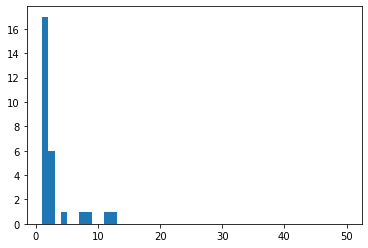

In [62]:
import glob
from tqdm.auto import tqdm
import yaml
from yaml import CLoader
import matplotlib.pyplot as plt
import numpy as np
import meshplot as mp
import igl
import os
from geomdl import BSpline, NURBS, trimming
from utils import load_dictionary_from_file



files0 = sorted(glob.glob("results_abc_00/*_stat.yaml"))
files0g = sorted(glob.glob("results_abc_00/*_stat.yaml"))

singularities_total = [0, 0, 0]
singularities_model = []

def evaluate_2dcurve(curve, orientation):
    crv2d = NURBS.Curve()
    crv2d.degree = curve["degree"]
    crv2d.ctrlpts = curve["poles"]
    crv2d.knotvector = curve["knots"]
    crv2d.weights = curve["weights"]
    crv2d.opt = ['reversed', not orientation]
    
    ps2d = crv2d.evalpts
    if crv2d.opt["reversed"]:
        ps2d.reverse()
    return np.array(ps2d)

for m in both[205:230]:
    f1 = sorted(glob.glob("results_abc_00/%s*.yaml"%m))
    f2 = sorted(glob.glob("results_abc_00uc/%s*.yaml"%m))
    geo_f1 = load_dictionary_from_file(f1[0])
    geo_f2 = load_dictionary_from_file(f2[0])
    stat_f1 = load_dictionary_from_file(f1[1])
    #stat_f2 = load_dictionary_from_file(f2[1])
    topo_f1 = load_dictionary_from_file(f1[2])
    #print(f1[0], f2[0])
    f = f1[1]
    
    for part_idx in range(len(geo_f1["parts"])):
        gf1 = geo_f1["parts"][part_idx]
        gf2 = geo_f2["parts"][part_idx]
        sf1 = stat_f1["parts"][part_idx]
        #sf2 = stat_f2["parts"][part_idx]
        tf1 = topo_f1["parts"][part_idx]
        sin_per_model = 0
        for fi in range(len(sf1)):
            face = sf1[fi]
            #face2 = gf2["surfaces"][fi]
#             try:
#                 if (sf2[surf_idx]["nr_singularities"] > 0 or sf1[surf_idx]["nr_singularities"] > 0) and not (gf2["surfaces"][surf_idx]["type"] == "Torus" or gf2["surfaces"][surf_idx]["type"] == "Sphere" or gf2["surfaces"][surf_idx]["type"] == "Cone"):
#                     print(f1[0])
#                     print(gf1["surfaces"][surf_idx]["type"], sf1[surf_idx]["has_singularities"], sf1[surf_idx]["nr_singularities"])
#                     print(gf2["surfaces"][surf_idx]["type"], sf2[surf_idx]["has_singularities"], sf2[surf_idx]["nr_singularities"])   
#             except Exception as e:
#                 print(e)

# for f in tqdm(files0g[0:20]):
#     #print(f)
#     with open(f, "r") as fi:
#         stat_dict = yaml.load(fi, Loader=CLoader)
        
#     with open(f.replace("_stat.yaml", "_geo.yaml"), "r") as fi:
#         geo_dict = yaml.load(fi, Loader=CLoader)
        
#     with open(f.replace("_stat.yaml", "_topo.yaml"), "r") as fi:
#         topo_dict = yaml.load(fi, Loader=CLoader)
        
#     for pi, part in enumerate(stat_dict["parts"]):
#         sin_per_model = 0
#         for fi, face in enumerate(part):
            singularities_total[0] += face["nr_singularities"]
            singularities_total[1] += 1
            if face["has_singularities"]:
                assert face["nr_singularities"] > 0
                singularities_total[2] += 1
            
            sin_per_model += face["nr_singularities"]
            #print(f, fi, face["nr_singularities"], gf2["surfaces"][fi]["type"])
            if face["nr_singularities"] > 0:
                if len(gf2["surfaces"]) != len(gf1["surfaces"]):
                    print("Broken surface lengths", f, fi)
                    continue
                else:
                    print(f, fi, gf2["surfaces"][fi]["type"], face["nr_singularities"])
                obj = f.replace("_stat.yaml", "_mesh")
                obj += "/%03i_%05i_mesh.obj"%(part_idx, fi)
                if not os.path.exists(obj):
                    continue
                verts, faces = igl.read_triangle_mesh(obj)
                p = mp.plot(verts, faces, return_plot=True)
                points3d = []
                colors3d = []
                points2d = []
                for isin in range(face["nr_singularities"]):
                    sin = face["singularities"][isin]
                    points3d.append(sin["point3d"])
                    colors3d.append(isin)
                    points2d.append(sin["point2d"])
                    
                points3d = np.array(points3d)
                points2d = np.array(points2d)
                colors3d = np.array(colors3d)
                scale3d = (np.max(points3d)-np.min(points3d))/20.0
                scale2d = (np.max(points2d)-np.min(points2d))/20.0
                p.add_points(points3d, c=colors3d, shading={"point_size": scale3d})
                #print(tf1, fi)
                loops = tf1["faces"][fi]["loops"]
                #print("Loops", loops, face["outer_wire"])
                ed = face["exact_domain"]
                domain_v = np.array([[ed[0], ed[2]], [ed[0], ed[3]], [ed[1], ed[3]], [ed[1], ed[2]]])
                domain_f = np.array([[0, 1, 2], [2, 3, 0]])
                domain_c = np.array([[1.0, 1.0, 1.0], [1.0, 1.0, 1.0]])
                p2d = mp.plot(domain_v, domain_f, c=domain_c, return_plot=True)
                for l in loops:
                    #print("Halfedges", topo_dict["parts"][pi]["loops"][l]["halfedges"])
                    for hei in tf1["loops"][l]["halfedges"]:
                        halfedge = tf1["halfedges"][hei]
                        he_orientation = halfedge["orientation_wrt_edge"]
                        edge = tf1["edges"][halfedge["edge"]]
                        curve3d = gf1["3dcurves"][edge["3dcurve"]]
                        curve2d = gf1["2dcurves"][halfedge["2dcurve"]]
                        
                        if curve2d["type"] != "BSpline":
                            print("Not converted", f, pi, curve2d["type"], curve3d["type"])
                            continue
                        
                        points2dc = evaluate_2dcurve(curve2d, he_orientation)
                        
                        if l == face["outer_wire"]:
                            color = "red"
                        else:
                            color = "black"
                            
                        lines_s = points2dc
                        lines_e = np.roll(points2dc, -1, axis=0)
                        
                        #print(hei, lines_s[0], lines_s[-1])
                        
                        #print(lines_s[0:2], lines_s[-2:])
                        #print(lines_e[0:2], lines_e[-2:])
                        
                        p2d.add_lines(lines_s[:-1], lines_e[:-1], shading={"line_color": color})
                        p2d.add_points(points2d, c=colors3d, shading={"point_size": scale2d})
                        
                
            
        singularities_model.append(sin_per_model)


print("Singularities per face (multi): %0.2f"%((singularities_total[0]/singularities_total[1])*100))
print("Singularities per face (single): %0.2f"%((singularities_total[2]/singularities_total[1])*100))
print("Singularities per part (single): %0.2f"%((sum(np.array(singularities_model)>0)/len(singularities_model)*100)))

plt.hist(singularities_model, bins=np.linspace(1, 50))
plt.show()